<a href="https://colab.research.google.com/github/JonasVerbickas/test-jupyter/blob/main/Final_NLP_CW2_Task_2_(torch_RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import nltk
import os
import re
import pandas as pd
import collections
import random
import torch
from torchsummary import summary
from torchtext.vocab import build_vocab_from_iterator
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from statistics import mean
from sklearn.model_selection import KFold

# 1. Preprocessing/Cleaning

In [58]:
USE_STEMMING_INSTEAD_OF_LEMMATIZATION = False

In [59]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
if USE_STEMMING_INSTEAD_OF_LEMMATIZATION:
  token_processing_fn = nltk.PorterStemmer().stem 
else:
  token_processing_fn = nltk.stem.WordNetLemmatizer().lemmatize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [81]:
def specialIpodProcessing(path_to_dataset, all_other_reviews_as_string):
  """
  Inserts [t] tags into text from 'ipod.txt'
  At an average review length taken from all other reviews
  """
  # calculate the average review length
  review_lengths = []
  curr_review_length = 0
  for line in all_other_reviews_as_string.split('\n'):
    if line == '[t]':
      if curr_review_length > 0:
        review_lengths.append(curr_review_length)
      curr_review_length = 0
    else:
      curr_review_length += 1
  average_len = int(mean(review_lengths))
  print("average_len used for ipod.txt =", average_len)
  # insert [t] every after each subset of `average_len` sentences
  curr_review_length = 0
  with open(os.path.join(path_to_dataset, 'ipod.txt')) as f:
    for line in f.readlines():
      if curr_review_length > average_len:
        all_other_reviews_as_string += "\n[t]"
        curr_review_length = 0
      all_other_reviews_as_string += line
      curr_review_length += 1
  return all_other_reviews_as_string

In [82]:
def create_concat_text_content_string(path_to_dataset):
  """
  Iterate through all of txt files in a given directory
  Concatenate the contents of each .txt file to a large string
  (Special processing for ipod.txt is applied)
  """
  file_contents = ""
  for filename in os.listdir(path_to_dataset):
    # skip readme
    if filename in ['README.txt', 'ipod.txt']:
      continue
    # append contents of other files to file_contents string
    starting_corpus_size = len(file_contents)
    with open(os.path.join(path_to_dataset, filename)) as f:
      file_contents += f.read()
    print("After appending", filename, "corpus sized increased to", starting_corpus_size, "->", len(file_contents))
  ## special processing for ipod.txt
  starting_corpus_size = len(file_contents)
  file_contents = specialIpodProcessing(path_to_dataset, file_contents)
  print("After appending ipod corpus sized increased to", starting_corpus_size, "->", len(file_contents))
  return file_contents

In [83]:
def removeAnnotationSymbols(sentence):
  static_removals = ['[t]', '[u]','[p]','[s]','[cc]','[cs]']
  for symbol in static_removals:
    sentence = sentence.replace(symbol, '')
  return sentence

In [84]:
def calculateSentement(unprocessed_sentence):
  semantic_tokens = re.findall('\[([+-]\d)\]', unprocessed_sentence)
  semantic_sum = 0
  for token in semantic_tokens:
    semantic_sum += int(token)
  return semantic_sum

In [85]:
def process_string_of_reviews_into_df(string_of_reviews):
  """
  1. Apply casefolding
  2. Expand contractions
  3. Tokenize sentances
  4. Ignore stop-words
  5. Ignore tokens that don't contain any alphanumeric characters
  6. Ignore sentiment analysis tokens e.g. `+3`
  """
  list_of_reviews = string_of_reviews.split("[t]\n")
  tokenized_sentence_sentiment_list = []
  for review in list_of_reviews:
    sentiment = 0
    processed_review = []
    review_split_into_lines = review.split('\n')
    for line in review_split_into_lines:
      sentiment_tags, _, sentence = line.partition("##")
      sentiment += calculateSentement(sentiment_tags)
      # I use `x` here instead of proper variable names
      # because it allows me switch the order of statements without having to rename variables
      # (This is very convinient when testing; and in my opinion makes the code more readable)
      x = removeAnnotationSymbols(sentence)
      x = x.casefold()
      x = nltk.tokenize.word_tokenize(x)
      x = [token_processing_fn(token) for token in x]
      processed_review += x
    tokenized_sentence_sentiment_list.append([review, processed_review, sentiment])
  df = pd.DataFrame(tokenized_sentence_sentiment_list, columns=['original review','processed review','sentiment'])
  return df


In [86]:
class ReviewDataset(torch.utils.data.Dataset):
  def __init__(self, path_to_review_folder):
        string_of_reviews = create_concat_text_content_string(path_to_review_folder)
        self.review_df = process_string_of_reviews_into_df(string_of_reviews)
        set_of_all_tokens = set([token for review in self.review_df['processed review'] for token in review])
        self.vocab = build_vocab_from_iterator([set_of_all_tokens], max_tokens=len(set_of_all_tokens), specials=["<unk>"])
        print(f"{len(self.vocab)=}")
        self.vocab.set_default_index(self.vocab["<unk>"])
        
  def __len__(self):
    return len(self.review_df)

  def __getitem__(self, idx):
    review = self.review_df.iloc[idx]
    return self.vocab(list(review["processed review"])), review['sentiment']


In [87]:
PATH_TO_REVIEWS = "/content/drive/MyDrive/Colab Notebooks/product_reviews"
dataset = ReviewDataset(PATH_TO_REVIEWS)

After appending Nokia_6600.txt corpus sized increased to 0 -> 56093
After appending norton.txt corpus sized increased to 56093 -> 95013
After appending Linksys_Router.txt corpus sized increased to 95013 -> 151947
After appending MicroMP3.txt corpus sized increased to 151947 -> 259727
After appending Diaper_Champ.txt corpus sized increased to 259727 -> 294831
After appending Hitachi_router.txt corpus sized increased to 294831 -> 325078
After appending Canon_S100.txt corpus sized increased to 325078 -> 353887
After appending Canon_PowerShot_SD500.txt corpus sized increased to 353887 -> 378520
After appending ipod corpus sized increased to 378520 -> 436758
len(self.vocab)=6006


# 2. Implementation of the Classifier

In [88]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_class, drop_out=0.2):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, dropout=drop_out,
                          num_layers=num_layers, bidirectional=True)
        # 2x because bidirectional RNN concats its outputs
        self.fc = nn.Linear(2*hidden_dim, num_class) 
        self.embedding_dropout = nn.Dropout(drop_out)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        embedded = self.embedding_dropout(embedded)
        y, hidden = self.rnn(embedded)
        y = self.fc(y)
        return self.sigmoid(y)

In [89]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_text, _label) in batch:
         label_list.append(_label)
         processed_text = torch.tensor(_text, dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = (torch.tensor(label_list, dtype=torch.int64)>0).float().reshape(-1, 1)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(DEVICE), text_list.to(DEVICE), offsets.to(DEVICE)

# 3. Experiments to Evaluate the Classifier

## Define logic required for training

In [90]:
# DEFINE HYPERPARAMS
EPOCHS = 15
LR = 1e-3 
K_FOLDS = 5
BATCH_SIZE = 1 
TRAIN_PERCENTAGE = 0.8
EMSIZE = 200 # embedding size used by the model
HIDDEN_SIZE = 16 # size of the hidden layer
NUM_LAYERS = 2
DROP_OUT = 0.5
vocab_size = len(dataset.vocab)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [91]:
model = TextClassificationModel(vocab_size, EMSIZE,
                                HIDDEN_SIZE, NUM_LAYERS, num_class=1,
                                drop_out=DROP_OUT).to(DEVICE)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,209,809 trainable parameters


In [92]:
# Define the training loop
def train(dataloader):
    correct_preds, total_preds, total_loss = 0, 0, 0
    model.train()
    for idx, (label, text, offsets) in tqdm(enumerate(dataloader), total=len(dataloader)):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) # prevent gradient explosion
        optimizer.step()
        total_loss += loss.item()
        # Threshold the predictions
        correct_preds += ((predicted_label>0.5).float() == label).sum().item()
        total_preds += label.size(0)
    accuracy = correct_preds/total_preds
    average_loss = total_loss/total_preds
    return accuracy, average_loss

In [93]:
# Define the validation loop
def evaluate(dataloader):
    model.eval()
    correct_preds, total_preds, total_loss = 0, 0, 0
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_loss += loss.item()
            correct_preds += ((predicted_label>0.5).float() == label).sum().item()
            total_preds += label.size(0)
    accuracy = correct_preds/total_preds
    average_loss = total_loss/total_preds
    return accuracy, average_loss

## Start training

In [94]:
# Split dataset
train_val_size = int(TRAIN_PERCENTAGE*(len(dataset)))
test_size = len(dataset) - train_val_size
train_val_set, test_set = torch.utils.data.random_split(dataset, [train_val_size, test_size])
kfold = KFold(n_splits=K_FOLDS)

In [95]:
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, collate_fn=collate_batch)

In [96]:
fold_val_accr = []
fold_train_accr = []
fold_test_accr = []
# Start training
for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_val_set)):
  print(f"\n\n!!========== FOLD #{fold} ============!!\n")
  # Create the dataloaders
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)
  train_dataloader = torch.utils.data.DataLoader(train_val_set, batch_size=BATCH_SIZE, collate_fn=collate_batch, sampler=train_subsampler)
  val_dataloader = torch.utils.data.DataLoader(train_val_set, batch_size=BATCH_SIZE, collate_fn=collate_batch, sampler=valid_subsampler)
  # Instantiate the model
  model = TextClassificationModel(vocab_size, EMSIZE,
                                  HIDDEN_SIZE, NUM_LAYERS, num_class=1,
                                  drop_out=DROP_OUT).to(DEVICE)
  # Instantiate optimization objects
  criterion = torch.nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
  # Keep track of losses throughout the epoch
  higest_val_accuracy = 0
  train_losses = []
  train_accrs = []
  val_losses = []
  val_accrs = []
  for epoch in range(1, EPOCHS + 1):
      train_acc, train_loss = train(train_dataloader)
      val_acc, val_loss = evaluate(val_dataloader)
      # if has accuracy is lower than in prev epoch - reduce the learning rate
      if higest_val_accuracy > val_acc:
        scheduler.step()
      highest_val_accuracy = max(higest_val_accuracy, val_acc)
      print('-' * 80)
      print(f'end of {epoch=} | {train_acc=:.4f} | {train_loss=:.6f} | {val_acc=:.4f} ')
      print('-' * 80)
      train_losses.append(train_loss)
      train_accrs.append(train_acc)
      val_accrs.append(val_acc)
      val_losses.append(val_loss)
  # append the last and (hopefully) highest accuracies 
  fold_val_accr.append(val_accrs[-1])
  fold_train_accr.append(train_accrs[-1])
  test_acc, test_loss = evaluate(test_dataloader)
  fold_test_accr.append(test_acc)



!!========== FOLD #0 ============!!



  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=1 | train_acc=0.5556 | train_loss=0.676288 | val_acc=0.7115 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=2 | train_acc=0.6184 | train_loss=1.056957 | val_acc=0.7115 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=3 | train_acc=0.6184 | train_loss=1.545678 | val_acc=0.7115 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=4 | train_acc=0.6232 | train_loss=1.442838 | val_acc=0.7115 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=5 | train_acc=0.6618 | train_loss=1.121898 | val_acc=0.7308 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=6 | train_acc=0.8116 | train_loss=0.602716 | val_acc=0.7692 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=7 | train_acc=0.8502 | train_loss=0.527974 | val_acc=0.8462 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=8 | train_acc=0.9275 | train_loss=0.194376 | val_acc=0.8846 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=9 | train_acc=0.9372 | train_loss=0.202942 | val_acc=0.9038 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=10 | train_acc=0.9517 | train_loss=0.194538 | val_acc=0.9038 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=11 | train_acc=0.9807 | train_loss=0.064427 | val_acc=0.9038 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=12 | train_acc=0.9662 | train_loss=0.113022 | val_acc=0.9038 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=13 | train_acc=0.9710 | train_loss=0.052170 | val_acc=0.8846 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=14 | train_acc=0.9952 | train_loss=0.013534 | val_acc=0.8846 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=15 | train_acc=0.9807 | train_loss=0.091346 | val_acc=0.8846 
--------------------------------------------------------------------------------


!!========== FOLD #1 ============!!



  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=1 | train_acc=0.5942 | train_loss=0.679119 | val_acc=0.5962 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=2 | train_acc=0.6473 | train_loss=1.010158 | val_acc=0.5962 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=3 | train_acc=0.6473 | train_loss=1.542686 | val_acc=0.5962 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=4 | train_acc=0.6522 | train_loss=1.403527 | val_acc=0.5962 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=5 | train_acc=0.6908 | train_loss=1.065896 | val_acc=0.6154 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=6 | train_acc=0.8019 | train_loss=0.556689 | val_acc=0.6346 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=7 | train_acc=0.8986 | train_loss=0.292340 | val_acc=0.6154 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=8 | train_acc=0.9275 | train_loss=0.322957 | val_acc=0.5769 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=9 | train_acc=0.9758 | train_loss=0.102289 | val_acc=0.6154 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=10 | train_acc=0.9614 | train_loss=0.168654 | val_acc=0.5962 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=11 | train_acc=0.9807 | train_loss=0.107742 | val_acc=0.5769 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=12 | train_acc=0.9855 | train_loss=0.050487 | val_acc=0.5769 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=13 | train_acc=0.9855 | train_loss=0.113937 | val_acc=0.5962 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=14 | train_acc=0.9758 | train_loss=0.134923 | val_acc=0.6154 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=15 | train_acc=0.9855 | train_loss=0.107210 | val_acc=0.6154 
--------------------------------------------------------------------------------


!!========== FOLD #2 ============!!



  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=1 | train_acc=0.6280 | train_loss=0.760519 | val_acc=0.5962 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=2 | train_acc=0.6473 | train_loss=1.302129 | val_acc=0.5962 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=3 | train_acc=0.6522 | train_loss=1.620208 | val_acc=0.5962 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=4 | train_acc=0.6473 | train_loss=1.554951 | val_acc=0.5962 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=5 | train_acc=0.6522 | train_loss=1.422818 | val_acc=0.5962 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=6 | train_acc=0.6860 | train_loss=1.159764 | val_acc=0.5962 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=7 | train_acc=0.8019 | train_loss=0.615154 | val_acc=0.6154 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=8 | train_acc=0.8502 | train_loss=0.447277 | val_acc=0.7692 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=9 | train_acc=0.9275 | train_loss=0.239289 | val_acc=0.7308 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=10 | train_acc=0.9324 | train_loss=0.310810 | val_acc=0.6154 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=11 | train_acc=0.9324 | train_loss=0.194970 | val_acc=0.7500 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=12 | train_acc=0.9614 | train_loss=0.065469 | val_acc=0.6731 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=13 | train_acc=0.9758 | train_loss=0.108360 | val_acc=0.7500 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=14 | train_acc=0.9710 | train_loss=0.099547 | val_acc=0.7500 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=15 | train_acc=0.9807 | train_loss=0.069325 | val_acc=0.7500 
--------------------------------------------------------------------------------


!!========== FOLD #3 ============!!



  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=1 | train_acc=0.5604 | train_loss=0.667951 | val_acc=0.6731 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=2 | train_acc=0.6280 | train_loss=1.061953 | val_acc=0.6731 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=3 | train_acc=0.6280 | train_loss=1.537740 | val_acc=0.6731 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=4 | train_acc=0.6522 | train_loss=1.288099 | val_acc=0.6731 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=5 | train_acc=0.7005 | train_loss=1.018557 | val_acc=0.6731 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=6 | train_acc=0.7874 | train_loss=0.711764 | val_acc=0.7308 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=7 | train_acc=0.8647 | train_loss=0.401422 | val_acc=0.7115 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=8 | train_acc=0.9227 | train_loss=0.341598 | val_acc=0.6731 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=9 | train_acc=0.9469 | train_loss=0.272590 | val_acc=0.7500 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=10 | train_acc=0.9420 | train_loss=0.247140 | val_acc=0.7500 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=11 | train_acc=0.9662 | train_loss=0.129894 | val_acc=0.7500 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=12 | train_acc=0.9710 | train_loss=0.095795 | val_acc=0.7308 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=13 | train_acc=0.9758 | train_loss=0.123444 | val_acc=0.7500 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=14 | train_acc=0.9855 | train_loss=0.039045 | val_acc=0.7692 
--------------------------------------------------------------------------------


  0%|          | 0/207 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=15 | train_acc=0.9903 | train_loss=0.011461 | val_acc=0.7692 
--------------------------------------------------------------------------------


!!========== FOLD #4 ============!!



  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=1 | train_acc=0.6394 | train_loss=0.662717 | val_acc=0.6078 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=2 | train_acc=0.6442 | train_loss=1.254518 | val_acc=0.6078 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=3 | train_acc=0.6442 | train_loss=1.466763 | val_acc=0.6078 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=4 | train_acc=0.6538 | train_loss=1.444167 | val_acc=0.6078 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=5 | train_acc=0.6779 | train_loss=1.061725 | val_acc=0.6275 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=6 | train_acc=0.8173 | train_loss=0.486015 | val_acc=0.6863 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=7 | train_acc=0.8702 | train_loss=0.387502 | val_acc=0.6863 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=8 | train_acc=0.9423 | train_loss=0.239271 | val_acc=0.6863 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=9 | train_acc=0.9231 | train_loss=0.208842 | val_acc=0.6863 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=10 | train_acc=0.9471 | train_loss=0.169862 | val_acc=0.7255 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=11 | train_acc=0.9663 | train_loss=0.073265 | val_acc=0.6863 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=12 | train_acc=0.9856 | train_loss=0.029002 | val_acc=0.7255 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=13 | train_acc=0.9952 | train_loss=0.015818 | val_acc=0.7255 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=14 | train_acc=0.9856 | train_loss=0.039136 | val_acc=0.7255 
--------------------------------------------------------------------------------


  0%|          | 0/208 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=15 | train_acc=0.9952 | train_loss=0.007601 | val_acc=0.6863 
--------------------------------------------------------------------------------


## Examine the results

### I look at how the training went throughout the last epoch
This allows me to see whether the model overfits

In [97]:
def plotStatThroughoutEpochs(label, train_stat, validation_stat):
  plt.plot(train_stat, label=f'Training {label}')
  plt.plot(validation_stat, label=f'Validation {label}')
  plt.xticks(range(len(train_stat)))
  plt.title(f'{label} over time')
  plt.xlabel('Epoch')
  plt.ylabel(f'{label}')
  plt.legend()
  plt.show()

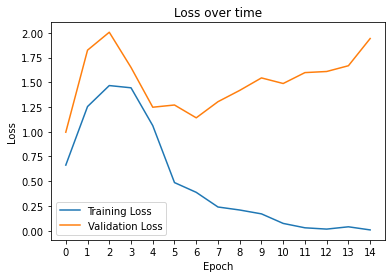

In [98]:
plotStatThroughoutEpochs("Loss", train_losses, val_losses)

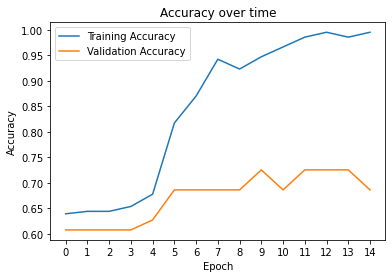

In [99]:
plotStatThroughoutEpochs("Accuracy", train_accrs, val_accrs)

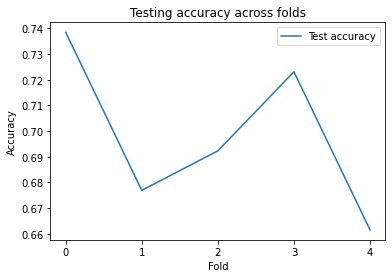

In [100]:
plt.plot(fold_test_accr, label=f'Test accuracy')
plt.xticks(range(len(fold_test_accr)))
plt.title(f'Testing accuracy across folds')
plt.xlabel('Fold')
plt.ylabel(f'Accuracy')
plt.legend()
plt.show()

### Examine results from different folds
Ideally we want to see low variance here

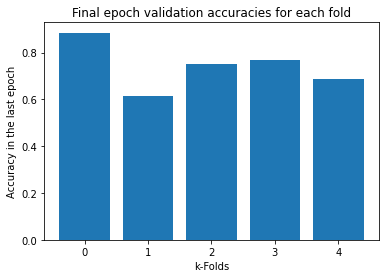

In [101]:
plt.title("Final epoch validation accuracies for each fold")
plt.xlabel("k-Folds")
plt.ylabel("Accuracy in the last epoch")
plt.bar(range(K_FOLDS), fold_val_accr)
plt.show()

### <mark>Test against custom input</mark>